In [1]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from google.colab import drive
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import itertools
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500
print("Tensorflow Hub Version: ", hub.__version__)

SEED = 42

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
USE_embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/newData.csv")
df = df[df.Product != 'Other']
df = df.sample(frac = 1)
train, test = train_test_split(df, test_size=0.2)


Tensorflow Hub Version:  0.12.0
Mounted at /content/drive


In [2]:
train_embeddings = USE_embed(train.Product)['outputs'].numpy()

kmeans = KMeans(n_clusters=len(list(df["Product"].unique())), random_state=SEED).fit(train_embeddings)
train.loc[:,'Clusters'] = None
train.loc[:,'Clusters'] = kmeans.labels_

#display(train.sort_values(by = 'Product'))

In [3]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train.Product, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(train.Product, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(train.Product, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(train.Product, kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_embeddings, train.Product, sample_size=1000))

#display(pd.crosstab(train['Clusters'], train['Product']))

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 1.000


In [4]:
def kmeans_predict(text_input, fitted_kmeans):
    tmp_embd = USE_embed([text_input])['outputs'].numpy()
    return fitted_kmeans.predict(tmp_embd)[0]

test["Clusters"] = test.Summary.apply(lambda t: kmeans_predict(text_input=t,fitted_kmeans=kmeans))
#display(pd.crosstab(test['Clusters'], test['Product']))

In [5]:
dic = {}
l = ['File System', 'Drivers', 'Networking', 'IO/Storage', 'v4l-dvb',
       'Virtualization', 'Memory Management',
       'Platform Specific/Hardware', 'ACPI', 'Timers',
       'Process Management', 'Tools', 'Power Management', 'EFI',
       'SCSI Drivers', 'Documentation', 'Tracing/Profiling',
       'Alternate Trees', 'Backports project']
for i in range(0,len(l)):
  dic[l[i]] = i
df['labels'] = df['Product'].map(dic)
class_names = l
train_data = df.loc[df.labels.notnull(),:].reset_index().copy()
train_data['labels'] = train_data['labels'].astype(int)
train_data['Summary'] = train_data['Summary'].astype(str)

categorical_labels = to_categorical(train_data['labels'].values, num_classes=None)
output_size = categorical_labels.shape[1]

print('Inpus Shape: {}, Output Shape: {}'.format(train_data['Summary'].shape, categorical_labels.shape))

Inpus Shape: (30997,), Output Shape: (30997, 19)


In [6]:
def build_model(embed, output_size=output_size):
    
    model = Sequential([
        Input(shape=[], dtype=tf.string),
        embed,
        Dense(output_size, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(USE_embed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  {'outputs': (None, 512)}  147354880 
                                                                 
 dense (Dense)               (None, 19)                9747      
                                                                 
Total params: 147,364,627
Trainable params: 9,747
Non-trainable params: 147,354,880
_________________________________________________________________


Epoch 1/40
3444/3444 [==============================] - 159s 39ms/step - loss: 1.8665 - accuracy: 0.4455 - val_loss: 1.6410 - val_accuracy: 0.5000
Epoch 2/40
3444/3444 [==============================] - 123s 36ms/step - loss: 1.5488 - accuracy: 0.5205 - val_loss: 1.5342 - val_accuracy: 0.5263
Epoch 3/40
3444/3444 [==============================] - 126s 36ms/step - loss: 1.4653 - accuracy: 0.5418 - val_loss: 1.4927 - val_accuracy: 0.5389
Epoch 4/40
3444/3444 [==============================] - 125s 36ms/step - loss: 1.4213 - accuracy: 0.5537 - val_loss: 1.4721 - val_accuracy: 0.5451
Epoch 5/40
3444/3444 [==============================] - 126s 37ms/step - loss: 1.3930 - accuracy: 0.5609 - val_loss: 1.4551 - val_accuracy: 0.5510
Epoch 6/40
3444/3444 [==============================] - 126s 37ms/step - loss: 1.3720 - accuracy: 0.5659 - val_loss: 1.4473 - val_accuracy: 0.5511
Epoch 7/40
3444/3444 [==============================] - 126s 37ms/step - loss: 1.3560 - accuracy: 0.5708 - val_loss: 1

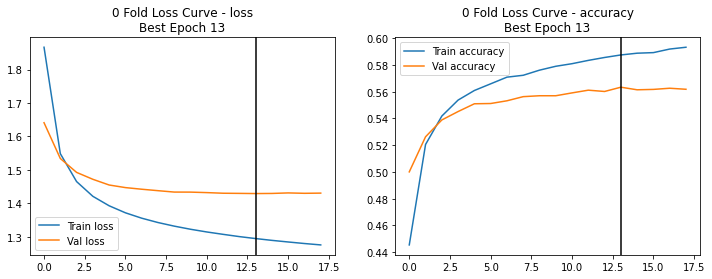

Epoch 1/40
3445/3445 [==============================] - 142s 39ms/step - loss: 1.8765 - accuracy: 0.4431 - val_loss: 1.6263 - val_accuracy: 0.5063
Epoch 2/40
3445/3445 [==============================] - 126s 37ms/step - loss: 1.5576 - accuracy: 0.5210 - val_loss: 1.5171 - val_accuracy: 0.5357
Epoch 3/40
3445/3445 [==============================] - 127s 37ms/step - loss: 1.4764 - accuracy: 0.5406 - val_loss: 1.4734 - val_accuracy: 0.5403
Epoch 4/40
3445/3445 [==============================] - 126s 37ms/step - loss: 1.4332 - accuracy: 0.5514 - val_loss: 1.4487 - val_accuracy: 0.5460
Epoch 5/40
3445/3445 [==============================] - 126s 36ms/step - loss: 1.4050 - accuracy: 0.5596 - val_loss: 1.4341 - val_accuracy: 0.5510
Epoch 6/40
3445/3445 [==============================] - 126s 36ms/step - loss: 1.3850 - accuracy: 0.5649 - val_loss: 1.4240 - val_accuracy: 0.5529
Epoch 7/40
3445/3445 [==============================] - 126s 36ms/step - loss: 1.3694 - accuracy: 0.5684 - val_loss: 1

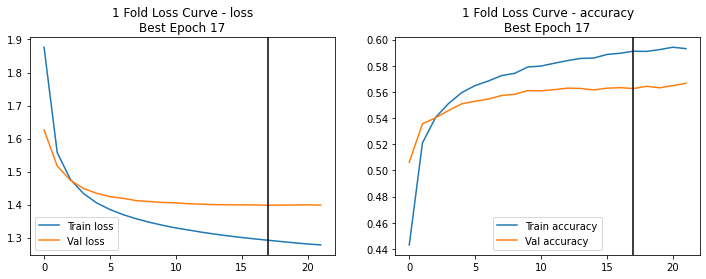

Epoch 1/40
3445/3445 [==============================] - 137s 37ms/step - loss: 1.8720 - accuracy: 0.4495 - val_loss: 1.6339 - val_accuracy: 0.5073
Epoch 2/40
3445/3445 [==============================] - 120s 35ms/step - loss: 1.5584 - accuracy: 0.5218 - val_loss: 1.5223 - val_accuracy: 0.5316
Epoch 3/40
3445/3445 [==============================] - 119s 35ms/step - loss: 1.4775 - accuracy: 0.5412 - val_loss: 1.4759 - val_accuracy: 0.5379
Epoch 4/40
3445/3445 [==============================] - 123s 36ms/step - loss: 1.4351 - accuracy: 0.5521 - val_loss: 1.4499 - val_accuracy: 0.5444
Epoch 5/40
3445/3445 [==============================] - 119s 35ms/step - loss: 1.4071 - accuracy: 0.5599 - val_loss: 1.4353 - val_accuracy: 0.5497
Epoch 6/40
3445/3445 [==============================] - 120s 35ms/step - loss: 1.3870 - accuracy: 0.5666 - val_loss: 1.4257 - val_accuracy: 0.5513
Epoch 7/40
3445/3445 [==============================] - 124s 36ms/step - loss: 1.3715 - accuracy: 0.5698 - val_loss: 1

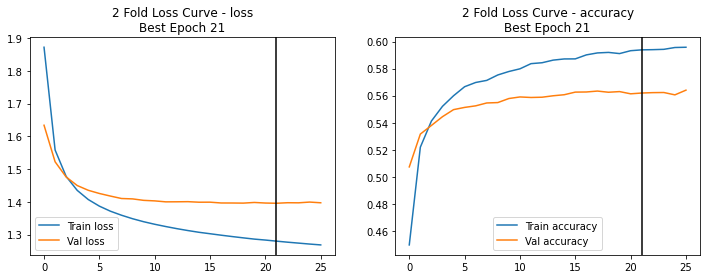

In [7]:
oof_preds = np.zeros([train_data.shape[0], output_size])

n_splits = 3
folds = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
plot_metrics = ['loss','accuracy']

fold_hist = {}
for i, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    model = build_model(USE_embed)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1,
                                 mode='min', baseline=None, restore_best_weights=True)
    
    history = model.fit(
        train_data.Summary[trn_idx].values,
        categorical_labels[trn_idx],
        validation_data=(
            train_data.Summary[val_idx].values,
            categorical_labels[val_idx]),
        epochs=40,
        batch_size=6,
        callbacks = [es],
        verbose=1)
    
    best_index = np.argmin(history.history['val_loss'])
    fold_hist[i] = history
    
    oof_preds[val_idx] = model.predict(train_data.Summary[val_idx].values)
    
    f, ax = plt.subplots(1,len(plot_metrics),figsize = [12,4])
    for p_i,metric in enumerate(plot_metrics):
        ax[p_i].plot(history.history[metric], label='Train ' + metric)
        ax[p_i].plot(history.history['val_' + metric], label='Val ' + metric)
        ax[p_i].set_title("{} Fold Loss Curve - {}\nBest Epoch {}".format(i, metric, best_index))
        ax[p_i].legend()
        ax[p_i].axvline(x=best_index, c='black')
    plt.show()

In [8]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 0.56
Confusion Matrix


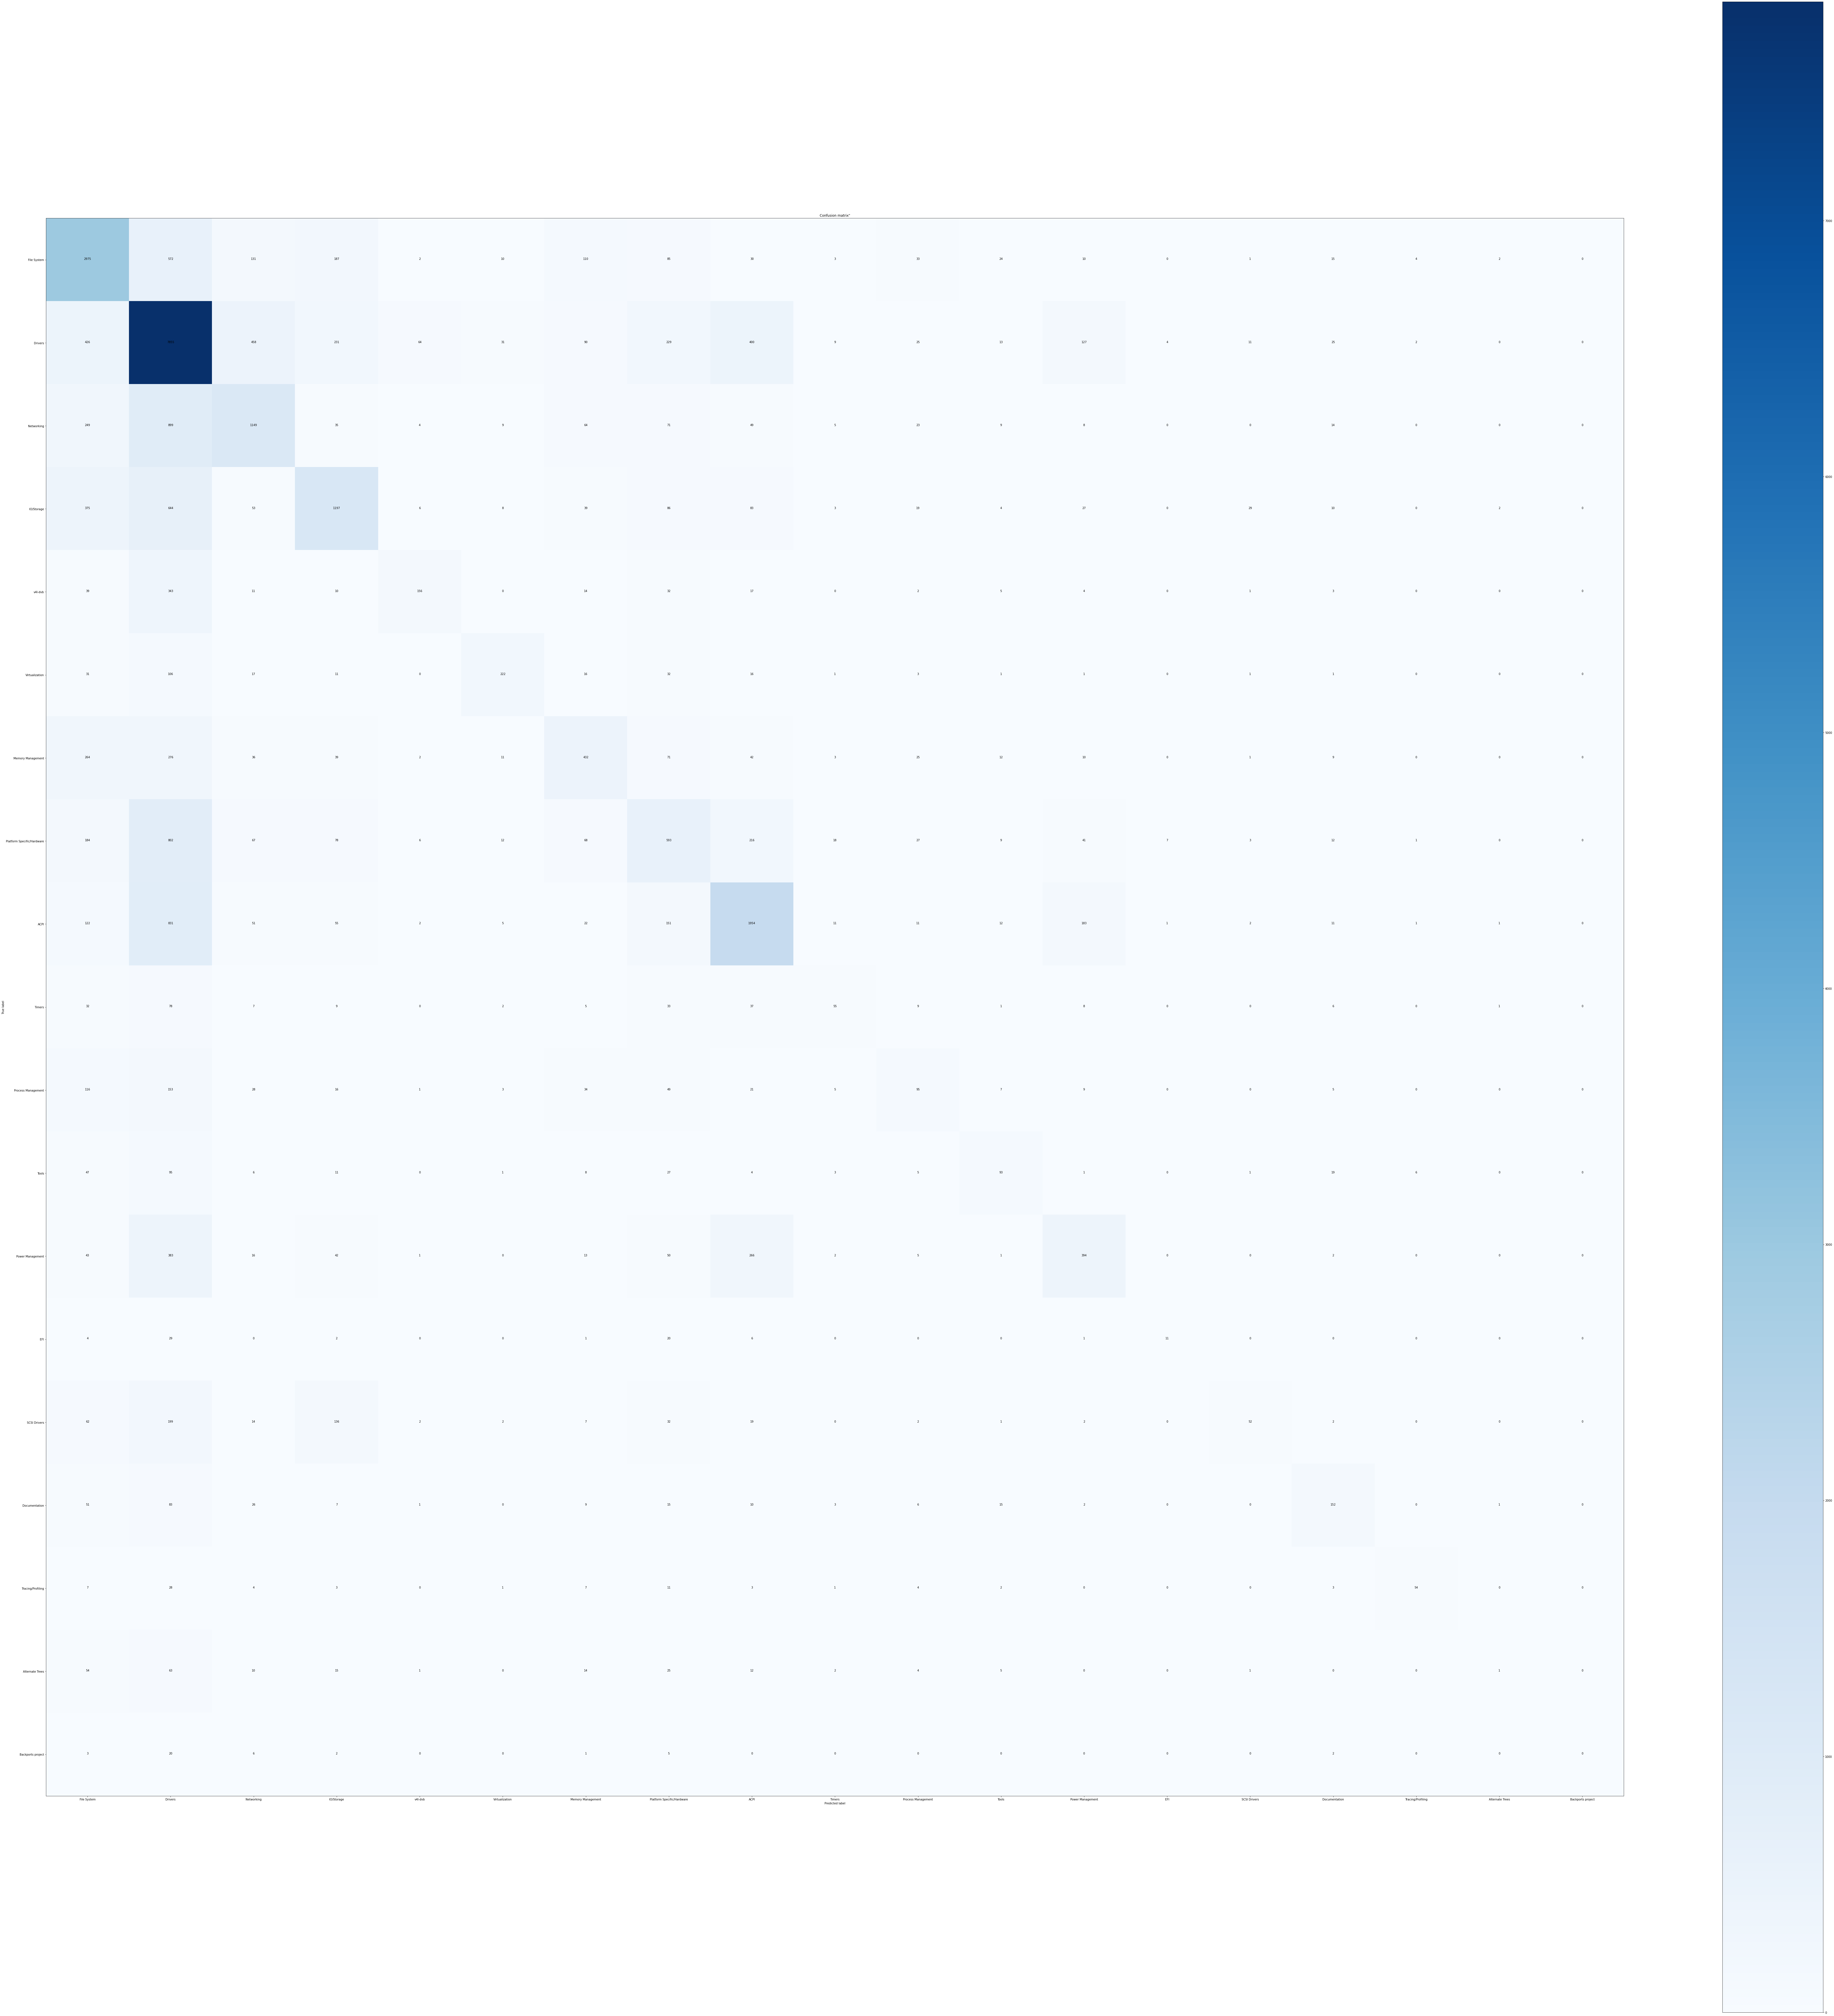

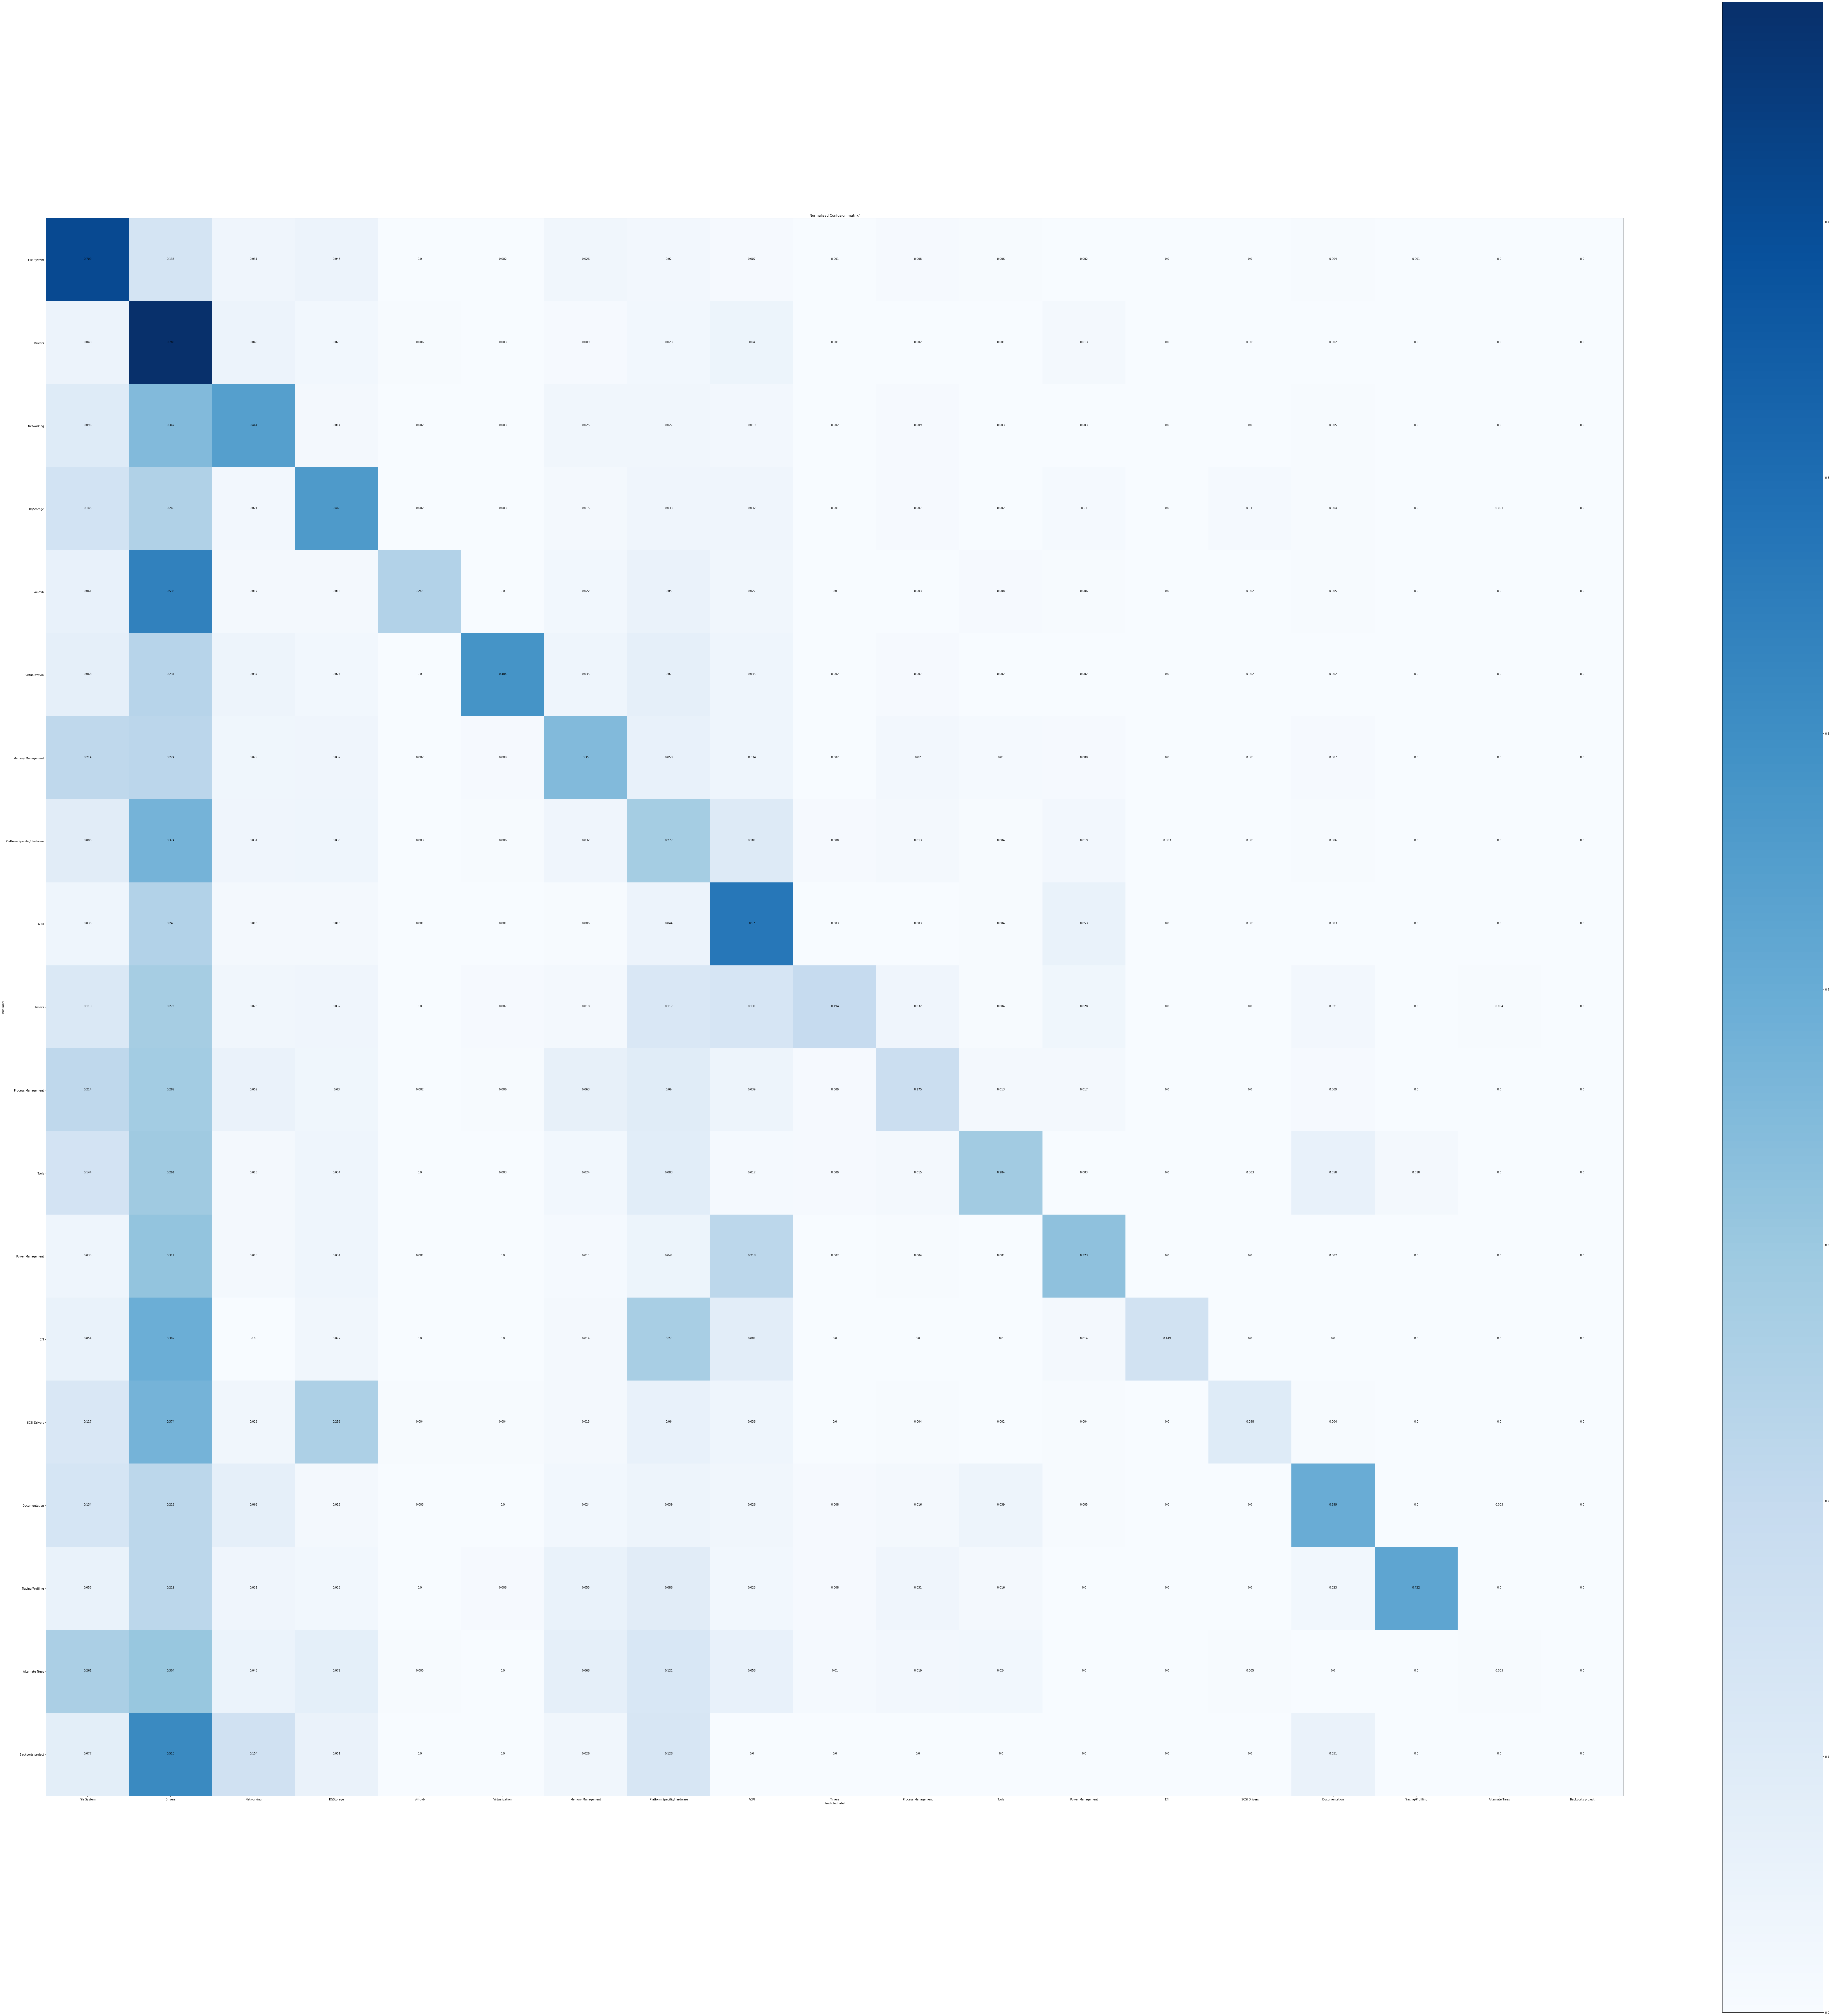

In [9]:
preds = oof_preds.argmax(axis = 1)
print("Accuracy: {:.2f}".format(metrics.accuracy_score(train_data['labels'], preds)))
print("Confusion Matrix")
fig, ax = plt.subplots(figsize=(100, 100))




plot_confusion_matrix(metrics.confusion_matrix(train_data['labels'], preds),
                          class_names,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues)




fig, ax = plt.subplots(figsize=(100, 100))
cm = metrics.confusion_matrix(train_data['labels'], preds, normalize = 'true').round(3)
plot_confusion_matrix(cm,
                          class_names,
                          title = 'Normalised Confusion matrix"',
                          cmap = plt.cm.Blues)
